# Observed concentrations and gradients of methane

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

import datasets
import emergent_constraint as ec
import figure_panels
import obs_aircraft
import util

## Load aircraft data

In [3]:
lat_lo_aircraft = -90.
lat_hi_aircraft = -15.
profiles_only = True
bin_aggregation_method = 'median'

parameters = ec.get_parameters()

In [4]:
campaign_info = obs_aircraft.get_campaign_info(verbose=False)

def load_data_aircraft(m):
    df = obs_aircraft.open_aircraft_data(m)    
    sel_loc = obs_aircraft.groups_select_profiles(df, lat_lo_aircraft, lat_hi_aircraft, 
                                                  profiles_only=profiles_only)
    return df.loc[sel_loc]

dfs_obs = {m: load_data_aircraft(m) for m in ['pfp', 'medusa', 'obs',]}

loading pfp
loading medusa


loading obs


## Upper troposphere CO<sub>2</sub> vs. CH<sub>4</sub>

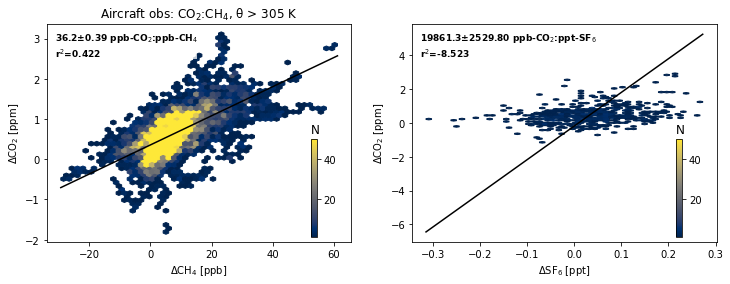

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def gas_scatter_upper_trop(theta_crit, ax, df_obs, constituent):
    txt_box_props = dict(facecolor='w', alpha=0.75, edgecolor='None', boxstyle='square,pad=0')
    
    CO2, Y = obs_aircraft.get_property_property(
        df=df_obs,
        campaign_sel_list=campaign_info.keys(),
        xname='co2',
        yname=constituent,
        theta_bin=(theta_crit, np.Inf),
        lat_range=(-90., -45.),
        filter_strat=True,
    )
    
    sc = ax.hexbin(Y, CO2, mincnt=1, vmax=50, gridsize=50, cmap='cividis',
                  ) #, C=df_sub.theta)

    cax = inset_axes(ax, width="2%", height="45%", loc='lower left',
                     bbox_to_anchor=(0.85, 0., 1, 1),
                     bbox_transform=ax.transAxes,
                    )    
    
    cb = plt.colorbar(sc, ax=ax, cax=cax)
    #cb.set_ticks(np.arange(310,  370, 10))
    cb.ax.set_title('N', loc='left') 
        
    fit = util.linreg_odr(Y, CO2) #linreg_odr
    x = np.array((min(Y), max(Y)))
    ax.plot(x, fit.predict(x), 'k-')

    ax.set_ylabel('$\Delta$CO$_2$ [ppm]')
    if constituent == 'ch4':
        ax.set_xlabel('$\Delta$CH$_4$ [ppb]')
        ax.set_title(f'Aircraft obs: CO$_2$:CH$_4$, θ > {theta_crit:0.0f} K')            
        #cb.ax.set_title('θ [K]', loc='left')
        units = 'ppb'
        c_str = 'CH$_4$'
    if constituent == 'sf6':
        ax.set_xlabel('$\Delta$SF$_6$ [ppt]')
        units = 'ppt'
        c_str = 'SF$_6$'
    str_text = (
        f'{1e3 * fit.beta[0]:0.1f}±{1e3 * fit.stderr_beta[0]:0.2f} ppb-CO$_2$:{units}-{c_str}\n' + 
        f'r$^2$={fit.r2:0.3f}'
    )
    
    xoff = np.diff(ax.get_xlim()) * 0.025
    yoff = -np.diff(ax.get_ylim()) * 0.15  
    ax.text(
        ax.get_xlim()[0]+xoff, ax.get_ylim()[1]+yoff, 
        str_text, 
        fontsize=9, fontweight='bold',
        bbox=txt_box_props,
    )  
    return fit.beta[0]
    
slope = {}
fig, axs = util.canvas(1, 2)
for p, constituent in enumerate(['ch4', 'sf6']):
    i, j = np.unravel_index(p, axs.shape)
    ax = axs[i, j]
    slope[constituent] = gas_scatter_upper_trop(
        305., ax, dfs_obs['obs'], constituent=constituent,
    )    


## Vertical gradients

In [6]:
theta_bins = obs_aircraft.make_theta_bins(
    **{k: parameters[k] for k in ['lbin', 'ubin', 'udθ', 'lbin_as_upper_bound',]}
)

dfs_campaign_gradients = {}; dfs_flight_gradients = {}
for c in ['co2', 'ch4']:
    dfs_campaign_gradients[c] = obs_aircraft.campaign_gradients(
        dfs_obs, campaign_info.keys(), theta_bins, 
        gradient_lat_range=parameters['gradient_lat_range'], 
        constituent=c,
    )
    dfs_flight_gradients[c] = obs_aircraft.flight_gradients(
        dfs_obs, theta_bins, 
        gradient_lat_range=parameters['gradient_lat_range'], 
        constituent=c,
    )    
    
dfs_campaign_gradients['ch4']

,ch4pfp,ch4mpfp,ch4,ch4qcls,ch4mqcls,gradient_mean,gradient_std
campaign,,,,,,,
HIPPO-1,1.290,-1.5600,-1.850,NaN,NaN,-0.280000,0.780000
HIPPO-2,-0.005,-0.0960,-0.705,NaN,NaN,-0.355000,0.048000
HIPPO-3,-6.520,-0.6990,-10.410,NaN,NaN,-8.465000,0.349500
HIPPO-5,-3.690,-2.3115,-9.705,NaN,NaN,-6.697500,1.155750
ORCAS-J,NaN,NaN,-1.415,2.6050,-2.840,0.595000,1.420000
ORCAS-F,NaN,NaN,-1.360,0.4150,-1.790,-0.472500,0.895000
ATOM-1,-0.490,-1.4280,-2.938,NaN,NaN,-1.714000,0.714000
ATOM-2,-1.640,-0.1570,-1.939,2.4945,-4.082,-0.361500,1.888356
ATOM-3,-3.590,-0.6655,-3.848,1.0820,-4.991,-2.118667,2.212664


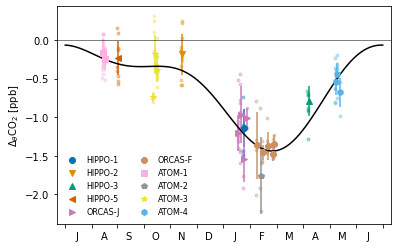

In [7]:
fig, axs = util.canvas(1, 1)
xco2, yco2 = figure_panels.obs_theta_gradient(dfs_flight_gradients['co2'], axs[0, 0])
ylm = axs[0, 0].get_ylim()

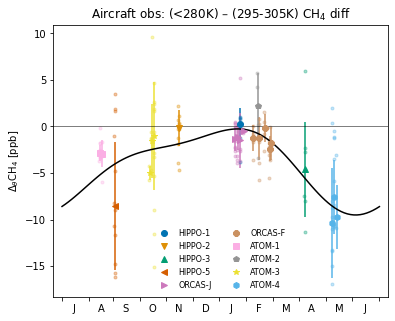

In [8]:
fig, axs = util.canvas(1, 1, figsize=(6, 5), use_gridspec=True, hspace=0.3)
axs = axs.ravel()
figure_panels.obs_theta_gradient(
    dfs_flight_gradients['ch4'], axs[0], constituent='ch4', theta_bins=theta_bins
);

## Load section

In [9]:
ds = datasets.aircraft_sections('obs').groupby('time.season').mean().compute()
ds

<xarray.Dataset>
Dimensions:              (z: 22, y: 20, season: 4, ye: 20, ze: 23)
Coordinates:
    ALT                  (z, y) float64 0.25 0.25 0.25 ... 10.75 10.75 10.75
    LAT                  (z, y) float64 -78.75 -76.25 -73.75 ... -33.75 -31.25
  * y                    (y) float64 -78.75 -76.25 -73.75 ... -33.75 -31.25
  * ye                   (ye) float64 -80.0 -77.5 -75.0 ... -37.5 -35.0 -32.5
  * z                    (z) float64 0.25 0.75 1.25 1.75 ... 9.75 10.25 10.75
  * ze                   (ze) float64 0.0 0.5 1.0 1.5 2.0 ... 9.5 10.0 10.5 11.0
  * season               (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables: (12/16)
    CH4_binned           (season, z, y) float64 nan 1.774e+03 ... 1.799e+03
    CO2_binned           (season, z, y) float64 nan 398.0 398.0 ... 396.1 396.1
    DCH4_binned          (season, z, y) float64 nan -3.556 ... 8.062 8.078
    DCO2_binned          (season, z, y) float64 nan -1.475 -1.52 ... 1.441 1.489
    DSF6_binned          (season, z, y) float64 nan nan nan ... 0.08326 0.06396
    N_CH4                (season, z, y) float64 nan 7.0 55.0 ... 5.0 6.0 7.5
    ...                   ...
    N_SF6                (season, z, y) float64 nan nan nan nan ... nan 2.0 1.0
    N_STRATOSPHERE       (season, z, y) float64 nan 7.0 55.0 ... 5.0 6.0 7.5
    SF6_binned           (season, z, y) float64 nan nan nan ... nan 9.26 7.975
    STRATOSPHERE_binned  (season, z, y) float64 nan 0.0 0.0 0.0 ... 0.0 0.0 0.0
    THETA                (season, z, y) float64 nan nan 264.8 ... 331.1 331.9
    THETA_binned         (season, z, y) float64 nan 265.3 264.0 ... 330.8 331.4

## Visualization

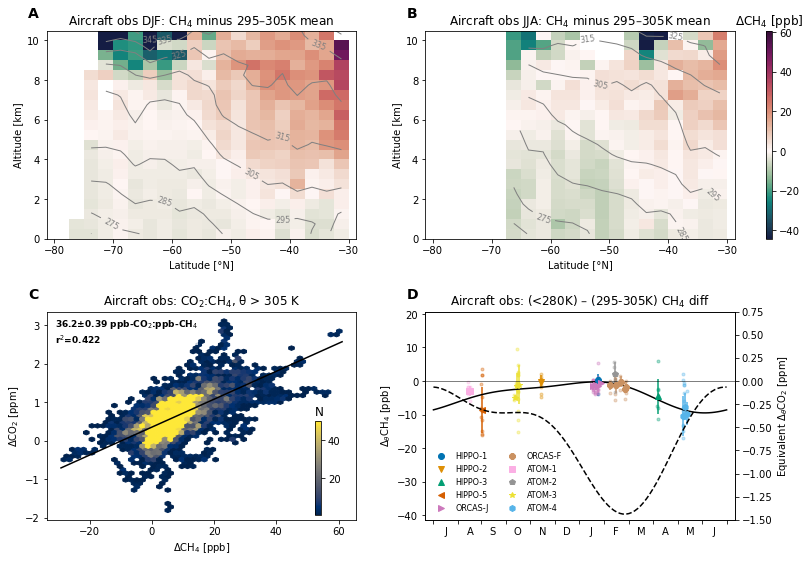

In [10]:
fig = plt.figure(figsize=(13, 9)) #dpi=300)

# set up plot grid
gs = gridspec.GridSpec(
    nrows=2, ncols=4, 
    width_ratios=(1, 0.02, 1, 0.02), 
    hspace=0.35, wspace=0.2,
)
axs = np.empty((2, 2)).astype(object)
axs[0, 0] = plt.subplot(gs[0, 0])
axs[0, 1] = plt.subplot(gs[0, 2])
axs[1, 0] = plt.subplot(gs[1, 0])
axs[1, 1] = plt.subplot(gs[1, 2])
cax = plt.subplot(gs[0, -1])


ax = axs[1, 0]
co2_per_ch4 = gas_scatter_upper_trop(305., ax, dfs_obs['obs'], constituent='ch4')

for n, season in enumerate(['DJF', 'JJA',]):
    ax = axs[0, n]
    cf = ax.pcolormesh(
        ds.y, ds.z, ds.DCH4_binned.sel(season=season),
        norm=colors.TwoSlopeNorm(
            vmin=figure_panels.levels[0]/co2_per_ch4, vcenter=0., vmax=figure_panels.levels[-1]/co2_per_ch4
        ),
        cmap=figure_panels.cmap,
        shading='nearest',
    )
    cs = ax.contour(
        ds.LAT, ds.ALT, ds.THETA.sel(season=season),
        levels=np.arange(255., 350., 10.),
        linewidths=1,
        colors='gray')    
    lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%d')    

    ax.set_title(f'Aircraft obs {season}: CH$_4$ minus 295–305K mean')    
    ax.set_ylim((0, 10.5))
    ax.set_xlim(-81.25, -28.75)

    ax.set_ylabel('Altitude [km]')
    ax.set_xlabel('Latitude [°N]')
    
cb = plt.colorbar(cf, cax=cax)   
cb.ax.set_title('$\Delta$CH$_4$ [ppb]')
    

ax = axs[1, 1]
figure_panels.obs_theta_gradient(
    dfs_flight_gradients['ch4'], 
    ax, constituent='ch4', 
    theta_bins=theta_bins,
)

ylm_def = np.array(ax.get_ylim()) * co2_per_ch4
ylm = np.array([-1.5, 0.75])
assert ylm[0] <= ylm_def[0]
assert ylm_def[1] <= ylm[1]
ax.set_ylim(ylm / co2_per_ch4)
axR = ax.twinx()
axR.set_ylim(np.array(ylm))
axR.set_ylabel('Equivalent $\Delta_{θ}$CO$_2$ [ppm]')
axR.plot(xco2, yco2, 'k--')

   
util.label_plots(fig, [ax for ax in axs.ravel()], xoff=-0.02)
util.savefig('methane')